<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Device-Checks" data-toc-modified-id="Device-Checks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Device Checks</a></span></li><li><span><a href="#Environment-Set-up" data-toc-modified-id="Environment-Set-up-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Environment Set-up</a></span><ul class="toc-item"><li><span><a href="#Preprocessing-States" data-toc-modified-id="Preprocessing-States-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocessing States</a></span></li></ul></li><li><span><a href="#Experience-Replay" data-toc-modified-id="Experience-Replay-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experience Replay</a></span></li><li><span><a href="#Double-Deep-Q-Learning-Agent" data-toc-modified-id="Double-Deep-Q-Learning-Agent-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Double Deep-Q-Learning Agent</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

## Device Checks

In [1]:
## CHECK AVAILABLE GPUs
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

AttributeError: module 'tensorflow' has no attribute 'config'

In [2]:
## PRINT DEVICE DETAILS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16683202041496500458
]


## Environment Set-up

In [3]:
## IMPORT LIBRARIES
import gym
from gym import Wrapper
from gym import spaces

import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
import torch

from collections import namedtuple, deque

import random

import tensorflow.keras as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import Huber

ImportError: cannot import name 'Huber' from 'tensorflow.keras.losses' (/usr/local/lib/python3.7/site-packages/tensorflow/_api/v1/keras/losses/__init__.py)

In [4]:
## INITIATE THE ENVIRONMENT
env = gym.make("MsPacmanDeterministic-v4")

# Print environment details
print('State shape is {}\n'.format(env.observation_space.shape))
print('Possible actions are {}: '.format(env.action_space.n))
print(env.env.get_action_meanings())

State shape is (210, 160, 3)

Possible actions are 9: 
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


In [5]:
env.reset()

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[228, 111, 111],
        [228, 111, 111],
        [228, 111, 111],
        ...,
        [228, 111, 111],
        [228, 111, 111],
        [228, 111, 111]],

       [[228, 111, 111],
        [228, 111, 111],
        [228, 111, 111],
        ...,
        [228, 111, 111],
        [228, 111, 111],
        [228, 111, 111]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

### Preprocessing States

In [6]:
## CREATE A FUNCTION TO PREPROCESS STATES
def preprocess_state(state):
    """Reshape and transform an RGB state to grayscale"""
    # Crop unecessary lives & points pannel and resize the image
    state = state[1:176:2, ::2]
    # Convert the image to greyscale
    state = state.mean(axis=2)
    # Normalize the image from -1 to +1
    state = (state - 128) / 128-1
    return state.reshape(88,80)

## CREATE A CLASS THAT MODIFIES THE MsPacmanDeterministic-v4 GYM ENVIRONMENT
class MsPacman(object):
    """Define environment parameters"""
    def __init__(self, env, stack=4):
        self.env = gym.make(env)
        self.stack = stack
        self.action_space = self.env.action_space
        self.actions = range(self.env.action_space.n)
        # Screen buffer of size 4 to be able to build state arrays of size [1, 4, 88, 80]
        self.state_buffer = deque()

    def reset(self):
        """Reshape a state into (88,80,1) and append state to the buffer"""
        # Clear the state buffer
        self.state_buffer = deque()
        state = self.env.reset()
        state = preprocess_state(state)
        stacked_state = np.stack([state for i in range(self.stack)], axis=0)

        for i in range(self.stack-1):
            self.state_buffer.append(state)
        return stacked_state
    
    def step(self, action_index):
        """Concatenate 3 previous states and current state to produce 
           a stacked state of shape (4,88,80)"""
        state, reward, done, info = self.env.step(self.actions[action_index])
        state = preprocess_state(state)
        
        

        previous_frames = np.array(self.state_buffer)
        stacked_state = np.empty((self.stack, 88, 80))
        stacked_state[:self.stack-1, :] = previous_frames
        stacked_state[self.stack-1] = state

        # Pop the oldest frame and add the current frame to the queue
        self.state_buffer.popleft()
        self.state_buffer.append(state)

        return stacked_state, reward, done, info
    
    def render(self):
        self.env.render()
        
    def close(self):
        self.env.close()

In [7]:
env = MsPacman("MsPacmanDeterministic-v4",stack=4)
print('State shape is {}\n'.format(np.shape(env.reset())))
print('Possible actions are {}: '.format(env.action_space.n))
print(env.env.get_action_meanings())

State shape is (4, 88, 80)

Possible actions are 9: 
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


## Experience Replay

In [8]:
## CREATE A CLASS THAT STORES THE AGENT'S EXPERIENCES AND RETRIEVES RANDOM BATCHES FROM ITS MEMORY
class ReplayMemory:
    
    def __init__(self, capacity=10000, batch_size=32):
        """Define the class parameters"""
        self.capacity = capacity
        self.batch_size = batch_size
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

    def push(self, state, action, reward, next_state, done):
        """Add a new experience to the memory buffer"""
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def __len__(self):
        return len(self.buffer)        
        
    def sample(self):
        """Sample a random batch of experiences from the memory"""
        samples = random.sample(self.buffer, self.batch_size)

        states = np.array([state[0] for state in samples])
        actions = np.array([action[1] for action in samples])
        rewards = np.array([reward[2] for reward in samples])
        next_states = np.array([next_state[3] for next_state in samples])
        dones = np.array([done[4] for done in samples])
        
        return (states, actions, rewards, next_states, dones)
    


## Double Deep-Q-Learning Agent

In [9]:
## CREATE THE DOUBLE DEEP-Q-LEARNING AGENT
class DDQNAgent:

    def __init__(self, action_space, capacity=10000, batch_size=32, 
                 learning_rate=0.0001, gamma = 0.99, epsilon=1.0, epsilon_min = 0.1, 
                 epsilon_decay = 0.999):
        """Create an instance of a Deep-Q-Network Agent"""
        self.action_size = action_space.n # number of possible actions
        self.learning_rate = learning_rate # model's learning rate
        self.gamma = gamma # discount rate
        self.batch_size = batch_size # size of batches sampled from memory
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min # threshold of epsilon
        self.epsilon_decay = epsilon_decay # decay of exploration rate
        self.model = self.build_model() # instance of dqn model
        self.target_model = self.build_model() # target model
        self.memory = ReplayMemory(capacity=capacity, batch_size=self.batch_size) # expirience replay memory
        
    def build_model(self):
        """Build the Convolutional DQN model"""
        model = Sequential()
        # add convolutional layers
        model.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=(4,88,80), data_format='channels_first')) # provide as input shape the state shape
        model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
        model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
        model.add(Flatten())
        # add fully connected layers with dropout
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.action_size, activation='linear')) # provide as output the number of possible states
        # compile model with Huber loss and RMSprop optimizer
        model.compile(loss=Huber(), optimizer=RMSprop(lr=self.learning_rate))
        return model
    

    def get_action(self, state):
        """Select action according to the epsilon-greedy policy"""
        # get the correct dimension that the models accepts
        state = np.expand_dims(state, axis=0)
        action = self.model.predict(state)
        if random.random() > self.epsilon:
            return np.argmax(action) # exploitation
        else:
            return random.choice(np.arange(self.action_size)) # exploration

    def train_model(self, states, actions, rewards, next_states, dones):
        """Train the model using random batches of experiences from the memory"""
        
        # start sampling from experience when memory is filled
        if len(self.memory) >= self.batch_size:
            states, actions, rewards, next_states, dones = self.memory.sample() # random memory sample
            # iterate over the batch to fix dimensions

            for i in range(len(states)):
                state, action, reward, next_state, done = states[i], actions[i], rewards[i], next_states[i], dones[i]
                state = np.expand_dims(state, axis=0)
                next_state = np.expand_dims(next_state, axis=0)
            
            targets = self.model.predict(states)
            target_next = self.model.predict(next_states) #DQN
            target_vals = self.target_model.predict(next_states) #Target model

            
            for i in range(self.batch_size):
                if dones[i]:
                    targets[i][actions[i]] = rewards[i]
                else:
                    # select an action using DQN model 
                    # update using the target model
                    a = np.argmax(target_next[i])
                    targets[i][actions[i]] = (rewards[i] + self.gamma * (target_vals[i][a]))
            
            # fit to get get the loss of the model
            loss = self.model.fit(states, targets, epochs=1, verbose=0).history['loss'][0]
            return loss
    
    def update_target_model(self):
        """Copy weights from the model used for action selection to the model used for computing targets"""
        self.target_model.set_weights(self.model.get_weights())
        
    def save_model(self):
        """Save the DQN Network"""
        self.model.save('local_model.h5')
        


In [10]:
# CREATE A RANDOM AGENT 
class RandomAgent:
    def __init__(self, action_space):
        """Create an instance of a random agent"""
        self.action_size = action_space.n
        
    def get_action(self):
        """Select action uniformly at random"""
        action = random.choice(np.arange(self.action_size))
        return action
    

## Training 

In [11]:
# INITIALIZE TRAINING PARAMETERS
EPISODES = 500 # Number of episodes
cumulative_rewards = []

# Get an instance of a DDQN agent
ddqnAgent = DDQNAgent(env.action_space, capacity=10000, batch_size=32, 
                 learning_rate=0.001, gamma = 0.99, epsilon=1.0, epsilon_min = 0.1, epsilon_decay = 0.999)

In [12]:
## TRAIN THE DDQN AGENT
print('Training initialised...\n')
for episode in range(1, EPISODES+1):
    init_time = time()
    state = env.reset()
    C = 0.1*EPISODES # target update step
    ep_reward = 0
    lives = 3
    done=False
    dead=False
    while not done:

        action = ddqnAgent.get_action(state)
        next_state, reward, done, info = env.step(action)
        reward = reward if not dead else -200  # penalise death        
        ddqnAgent.memory.push(state, action, reward, next_state, done)

        if ddqnAgent.epsilon >= ddqnAgent.epsilon_min: 
            ddqnAgent.epsilon *= ddqnAgent.epsilon_decay # decaying exploration/exploitation

        loss = ddqnAgent.train_model(action, state, next_state, reward, done)

        ep_reward += reward
        state = next_state
        dead = info['ale.lives'] < lives
        lives = info['ale.lives']
    
    time_taken = time() - init_time # time taken to complete one episode
    
    if episode % C == 0:
        ddqnAgent.update_target_model()
    
    cumulative_rewards.append(ep_reward)

    if episode % 20 == 0:
        print('Episode {} of {}:\n   score: {:.1f} \n   loss: {} \n   \u03B5: {:.2f} \n   time taken: {:.3f} sec'.format(episode, EPISODES, ep_reward, loss, ddqnAgent.epsilon, time_taken))
        ddqnAgent.save_model()
        
print('\nTraining ended.')

Training initialised...

Episode 20 of 500:
   score: 170.0 
   loss: 0.06554169952869415 
   ε: 0.10 
   time taken: 130.524 sec
Episode 40 of 500:
   score: 670.0 
   loss: 0.03577377647161484 
   ε: 0.10 
   time taken: 86.885 sec
Episode 60 of 500:
   score: 40.0 
   loss: 0.09844212234020233 
   ε: 0.10 
   time taken: 109.583 sec
Episode 80 of 500:
   score: 140.0 
   loss: 0.13102728128433228 
   ε: 0.10 
   time taken: 78.446 sec
Episode 100 of 500:
   score: 330.0 
   loss: 0.09858923405408859 
   ε: 0.10 
   time taken: 95.736 sec
Episode 120 of 500:
   score: -30.0 
   loss: 0.20458893477916718 
   ε: 0.10 
   time taken: 83.014 sec
Episode 140 of 500:
   score: -100.0 
   loss: 0.06571658700704575 
   ε: 0.10 
   time taken: 85.631 sec
Episode 160 of 500:
   score: 30.0 
   loss: 0.03297359496355057 
   ε: 0.10 
   time taken: 68.635 sec
Episode 180 of 500:
   score: 1060.0 
   loss: 0.0984458327293396 
   ε: 0.10 
   time taken: 132.873 sec
Episode 200 of 500:
   score: -1

## Evaluation

Text(0.5, 1.0, 'Cumulative Reward per Episode')

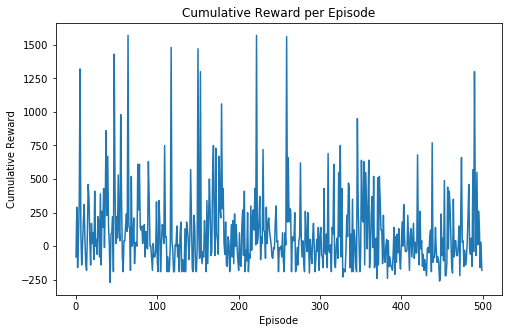

In [13]:
# PLOT TIME-PROGRESSION INDICES
plt.figure(figsize=(8,5))

# Cumulative Reward per episode
plt.plot(cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward per Episode')


In [ ]:
## EVALUATE THE TRAINED DDQN AGENT AGAINST A RANDOM AGENT
saved_model = 'local_model.h5'
DDQN_score = []
test_agent = load_model(saved_model)
RAND_score = []
RAND_agent = RandomAgent(env.action_space)
runs = 1

# Run the trained agent for one episode
for run in range(1,runs+1):
    state = env.reset()
    state = np.expand_dims(state, axis=0)
    ep_reward = 0
    done = False
    while not done:
        action = test_agent.predict(state)
        env.render()
        next_state, reward, done, info = env.step(np.argmax(action))
        ep_reward += reward
        state = next_state
        state = np.expand_dims(state, axis=0)
    DDQN_score.append(ep_reward)    
    env.close()

# Run the random agent for one episode
for run in range(1,runs+1):
    state = env.reset()
    ep_reward = 0
    done = False
    while not done:
        action = RAND_agent.get_action()
        env.render()
        next_state, reward, done, info = env.step(action)
        ep_reward += reward
        state = next_state
    RAND_score.append(ep_reward)    
    env.close()

print('Trained agent score: {}, Random agent score: {}'.format(DDQN_score,RAND_score))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\python38\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\python38\lib\site-packages\IPython\core\ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "c:\python38\lib\site-packages\IPython\core\ultratb.py", line 316, in wrapped
    return f(*args, **kwargs)
  File "c:\python38\lib\site-packages\IPython\core\ultratb.py", line 350, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "c:\python38\lib\inspect.py", line 1503, in getinnerframes
    frameinfo = (tb.tb_frame,) + getframeinfo(tb, context)
  File "c:\python38\lib\inspect.py", line 1461, in getf

KeyboardInterrupt: 

KeyboardInterrupt: 